In [1]:
## Finding soln to coupled eq.s
from scipy.integrate import solve_ivp,odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.special import hyp2f1

In [4]:
# Define Ea^2 = H/H0 a^2 to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

def phi_dot(a, k, params, cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    delta, phi, theta_r0, theta_r1, v = params
    Omega_m = Omega_c + Omega_b
    
    return -(Omega_m*delta + 4*Omega_r*theta_r0/a)/(2*Easquared(a, cosmo)**2) \
           - k**2 *phi*a/(3*Easquared(a, cosmo)**2) - phi/a + 2*alpha_C*phi/(a*Easquared(a, cosmo)**2)
#+ 2*alpha_C*phi/(k**2 * a*Easquared(a, cosmo)**2)

def theta_r0_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return - k*theta_r1/Easquared(a, cosmo) + phi_dot(a, k, params, cosmo)

def theta_r1_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return k*(theta_r0 + phi)/(3*Easquared(a, cosmo))

def delta_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return 3*phi_dot(a, k, params, cosmo) + k**2 * v/Easquared(a, cosmo)

def v_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -v/a -phi/Easquared(a, cosmo)

def 

def solution_coupled(a,params, cosmo, k):
    return [delta_dot(a, k, params, cosmo),\
           phi_dot(a, k, params, cosmo),\
           theta_r0_dot(a, k, params, cosmo),\
           theta_r1_dot(a, k, params, cosmo),
           v_dot(a, k, params, cosmo)]

# early universe boundary conditions
def BCs_earlyuniverse(cosmo, a_i):
    
    return np.array([3*(cosmo[-1] -cosmo[-2])/(2*cosmo[-2]),
                     1,
                     (cosmo[-1] -cosmo[-2])/(2*cosmo[-2]),
                     0,0])



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# comoving distance between a_min and a_max
def xi(a_min, a_max,cosmo):
    return sc.integrate.quad(lambda x: 1/(Easquared(x,cosmo)), a_min, a_max)[0]

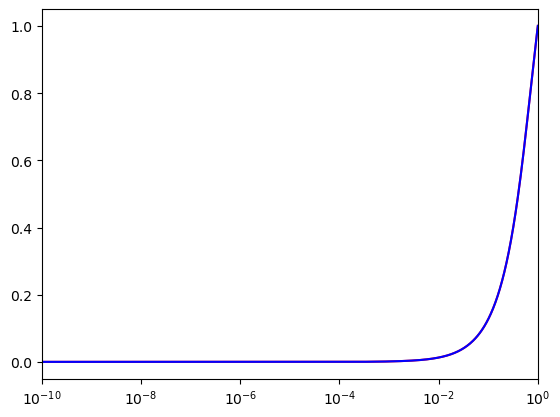

In [5]:
k = 80
a_0 = 1e-15
a_1 = 1e-15
Omg_rad = 9.227e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda x,y: solution_coupled(x,y, cosmo, k)
soln = solve_ivp(funct,
                  (a_0,1),
                  BCs_earlyuniverse(cosmo, a_0),# + np.array([1e-9,0,1e-9,0,0]),
                  t_eval=np.logspace(np.log10(a_0), 0, 1000), 
                  method ='BDF', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

plt.plot(soln.t,soln.y[0]/soln.y[0][-1], color="r")


# Showing that quasistatic approximation doesn't work
#soln_approx = solve_for_growth(np.logspace(np.log10(1e-6), 0, 500), cosmo, [k,k], soln.y[0][find_nearest(soln.t, 1e-6)]/soln.y[0][-1])[0][0]
#plt.plot(np.logspace(np.log10(1e-6), 0, 500),soln_approx, color="g")

alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

funct1 = lambda x,y: solution_coupled(x,y, cosmo, k)
#soln1 = solve_ivp(funct1,(a_1,1), np.array([soln.y[0][find_nearest(soln.t,a_1)],soln.y[1][find_nearest(soln.t,a_1)],soln.y[2][find_nearest(soln.t,a_1)],soln.y[3][find_nearest(soln.t,a_1)],soln.y[4][find_nearest(soln.t,a_1)]]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method="BDF", atol = 1e-11, rtol=1e-13,max_step=(1 - a_1) / 5000)
#soln1 = solve_ivp(funct1,(a_1,1), np.array([soln.y[0][find_nearest(soln.t,a_1)],phi_funct_lowk(a_1,k,cosmo),soln.y[2][find_nearest(soln.t,a_1)],soln.y[3][find_nearest(soln.t,a_1)],soln.y[4][find_nearest(soln.t,a_1)]]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method ='LSODA', rtol =1e-13)

#soln1 = solve_ivp(funct1,(a_1,1), np.array([3/2,1,1/2,-k*a_1/(6*Easquared(a_1, cosmo)), a_1/(2*Easquared(a_1, cosmo))]),\
#                  t_eval=np.logspace(np.log10(a_1), 0, 1000), method ='LSODA', rtol =1e-12)

"""
soln1 = solve_ivp(funct1,
                  (a_1,1),
                  np.array([3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,1,(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,\
                  -k*a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_1, cosmo)), \
                  a_1*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_1, cosmo))]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)
"""

soln1 = solve_ivp(funct1,
                  (a_1,1),
                  BCs_earlyuniverse(cosmo, a_1),# + np.array([1e-9,0,1e-9,0,0]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='BDF', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

plt.plot(soln1.t,soln1.y[0]/soln1.y[0][-1], color="b")

plt.xlim(1e-10,1)
plt.xscale("log")
#plt.yscale("log")

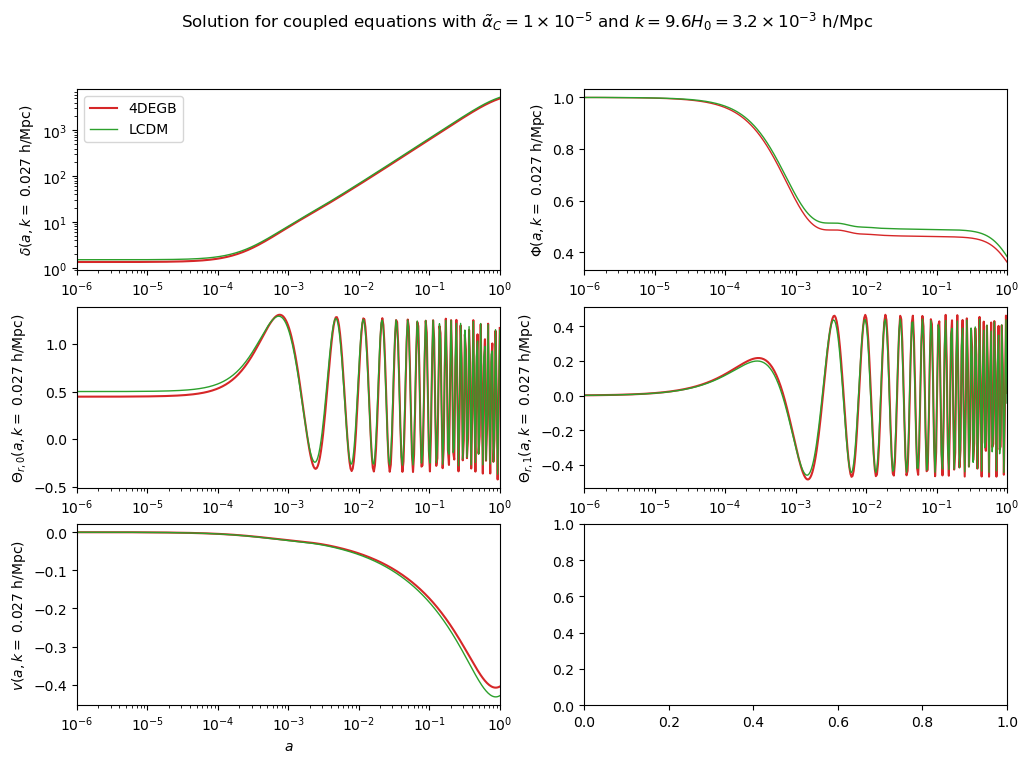

In [6]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
fig.suptitle(r'Solution for coupled equations with $\tilde{\alpha}_C = 1 \times 10^{-5}$ and $k = 9.6 H_0 = 3.2 \times 10^{-3}$ h/Mpc')


ax1.plot(soln1.t,-soln1.y[0], 'tab:red', label = "4DEGB")
ax1.set_ylabel(r"$\delta(a, k= $ %.3f h/Mpc)" % float(k/3e3))
ax1.set_xlabel(r"$a$")

ax2.plot(soln1.t,soln1.y[1], 'tab:red',linewidth=1)
ax2.set_ylabel(r"$\Phi(a, k= $ %.3f h/Mpc)" % float(k/3e3))
ax2.set_xlabel(r"$a$")

ax3.plot(soln1.t,-soln1.y[2], 'tab:red')
ax3.set_ylabel(r"$\Theta_{r,0}(a, k= $ %.3f h/Mpc)" % float(k/3e3))
ax3.set_xlabel(r"$a$")

ax4.plot(soln1.t,soln1.y[3], 'tab:red')
ax4.set_ylabel(r"$\Theta_{r,1}(a, k= $ %.3f h/Mpc)" % float(k/3e3))
ax4.set_xlabel(r"$a$")

ax5.plot(soln1.t,soln1.y[4], 'tab:red')
ax5.set_ylabel(r"$v(a, k= $ %.3f h/Mpc)" % float(k/3e3))
ax5.set_xlabel(r"$a$")



ax1.plot(soln.t,-soln.y[0], 'tab:green', label = "LCDM", linewidth=1)
ax2.plot(soln.t,soln.y[1], 'tab:green', linewidth=1)
ax3.plot(soln.t,-soln.y[2], 'tab:green', linewidth=1)
ax4.plot(soln.t,soln.y[3], 'tab:green', linewidth=1)
ax5.plot(soln.t,soln.y[4], 'tab:green', linewidth=1)

"""ax1.plot(soln2.t,soln2.y[0], 'tab:blue', label = "4DEGB_Corrected", linewidth=1)
ax2.plot(soln2.t,soln2.y[1], 'tab:blue', linewidth=1)
ax3.plot(soln2.t,soln2.y[2], 'tab:blue', linewidth=1)
ax4.plot(soln2.t,soln2.y[3], 'tab:blue', linewidth=1)
ax5.plot(soln2.t,soln2.y[4], 'tab:blue', linewidth=1)
"""
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

#ax2.plot(soln.t, phi_funct_lowk(soln.t,k,cosmo), color="b",linewidth=1)
#ax2.plot(soln.t, phi_funct_lowk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0]), color="orange",linewidth=1)

#ax2.plot(soln.t, phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])/phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[0], color="g",linewidth=3)

ax1.set_xscale("log")
ax1.set_yscale("log")
#ax1.set_ylim(-1.8,-1.3)
ax1.set_xlim(1e-6,1)
ax2.set_xscale("log")
#ax2.set_yscale("log")
ax2.set_xlim(1e-6,1)
#ax2.set_ylim(0.9,1.1)
ax3.set_xscale("log")
#ax3.set_yscale("log")
ax3.set_xlim(1e-6,1)
#ax3.set_ylim(-0.6,-0.4)
ax4.set_xscale("log")
#ax4.set_yscale("log")
ax4.set_xlim(1e-6,1)
ax5.set_xscale("log")
#ax5.set_yscale("log")
ax5.set_xlim(1e-6,1)

ax1.legend()
#ax2.plot([5e-4,5e-4],[0.8,1])

#plt.savefig("numerical_soln_coupled1")


In [9]:
# Find k_min

# distance between us and CMB
xi_max = xi(1/1101, 1,cosmo)

k_min = 2/xi_max
print(k_min)

0.6404964595966943


0.977490359015692
1.30037728328646


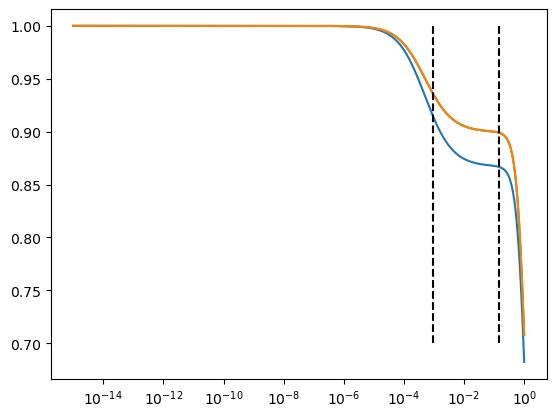

In [10]:
alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda x,y: solution_coupled(x,y, cosmo, k_min)
soln = solve_ivp(funct,
                 (a_0,1), 
                 BCs_earlyuniverse(cosmo, a_0),
                 t_eval=np.logspace(np.log10(a_0), 0, 1000), 
                 method ='LSODA', 
                 rtol =1e-4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]

funct1 = lambda x,y: solution_coupled(x,y, cosmo, k_min)

soln1 = solve_ivp(funct1,
                  (a_1,1),
                  BCs_earlyuniverse(cosmo, a_1) + np.array([1e-9,0,1e-9,0,0]),
                  t_eval=np.logspace(np.log10(a_1), 0, 1000), 
                  method ='LSODA', 
                  atol = 1e-11, 
                  rtol=1e-13,
                  max_step=(1 - a_1) / 5000)

#print(soln1.y[0][find_nearest(soln.t,1e-10)]/soln1.y[0][0])
#print(soln1.y[1][find_nearest(soln.t,1e-10)]/soln1.y[1][0])
#print(soln1.y[2][find_nearest(soln.t,1e-10)]/soln1.y[2][0])

phi_EGB = soln1.y[1]

phi_GR = soln.y[1]

plt.plot(soln.t,phi_EGB)
plt.plot(soln.t,soln.y[1], 'tab:green')
plt.plot(soln.t,phi_GR)
a_matterdom = 1.4e-1
plt.plot(np.ones(2)/1101, [0.7,1], "k--")
plt.plot(np.ones(2)*1.4e-1, [0.7,1], "k--")

phi_EGB_CMB = phi_EGB[find_nearest(soln.t,1/1101)]
phi_GR_CMB = phi_GR[find_nearest(soln.t,1/1101)]
phi_EGB_matterdom = phi_EGB[find_nearest(soln.t,a_matterdom)]
phi_GR_matterdom = phi_GR[find_nearest(soln.t,a_matterdom)]

#print(phi_EGB_matterdom)
#print(phi_GR_matterdom)
#print(phi_EGB_CMB)
#print(phi_GR_CMB)
print(phi_EGB_CMB/phi_GR_CMB)


# WE NEED TO DISCUSS -- I'm not sure a_matterdom is correct, and I'm not sure this measure here is correct
print((phi_EGB_CMB - phi_EGB_matterdom)/(phi_GR_CMB - phi_GR_matterdom))
plt.xscale("log")